Connected Agent (CAD)

This notebook runs the FULL connected CAD agent:
1. Design Intent Clarification
2. Design Intent Parsing
3. Design Planning
4. Human-in-the-Loop approval

This is the ONLY notebook that should be used to run the agent end-to-end.

In [7]:
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.types import Command

from IPython.display import Image, display

In [8]:
%%writefile ../src/cad_agent_from_scratch/cad_shared_state.py

"""
Shared State Definitions for the Agentic CAD Workflow.

This module defines a SINGLE shared LangGraph state used across
multiple workflow stages, including:
1. Design Intent Clarification & Parsing
2. Design Planning (Human-in-the-Loop)
3. Future CAD code generation and evaluation steps

Responsibilities:
- Provide a unified state schema across all agent stages
- Ensure state continuity when composing multiple LangGraph workflows
- Prevent state loss at workflow boundaries
"""

from typing_extensions import Optional, Annotated, Sequence

from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage


class CADSharedState(MessagesState):
    """
    Unified shared state for the CAD agent.

    This state is intentionally used by ALL workflow stages to
    avoid schema coercion and key loss when composing graphs.
    """

    # -----------------------------------------------------------------
    # Step 1: Design Intent Clarification & Parsing outputs
    # -----------------------------------------------------------------

    design_intent: Optional[str]
    parsed_intent: Optional[dict]
    needs_clarification: bool = True
    clarification_messages: Annotated[Sequence[BaseMessage], add_messages]

    # -----------------------------------------------------------------
    # Step 2: Design Planning (Human-in-the-Loop) outputs
    # -----------------------------------------------------------------

    design_plan: Optional[str]
    plan_messages: Annotated[Sequence[BaseMessage], add_messages]
    human_feedback: Optional[str]


Writing ../src/cad_agent_from_scratch/cad_shared_state.py


In [9]:
from cad_agent_from_scratch.cad_shared_state import CADSharedState

from cad_agent_from_scratch.design_intent_workflow import (
    design_intent_workflow
)

from cad_agent_from_scratch.design_planning_workflow import (
    design_planning_workflow
)

In [10]:
# Build the connected CAD agent
builder = StateGraph(CADSharedState)

builder.add_node("design_intent", design_intent_workflow)
builder.add_node("design_planning", design_planning_workflow)

builder.add_edge(START, "design_intent")
builder.add_edge("design_intent", "design_planning")

# Compile with checkpointing for HITL
connected_agent = builder.compile(
    checkpointer=InMemorySaver()
)


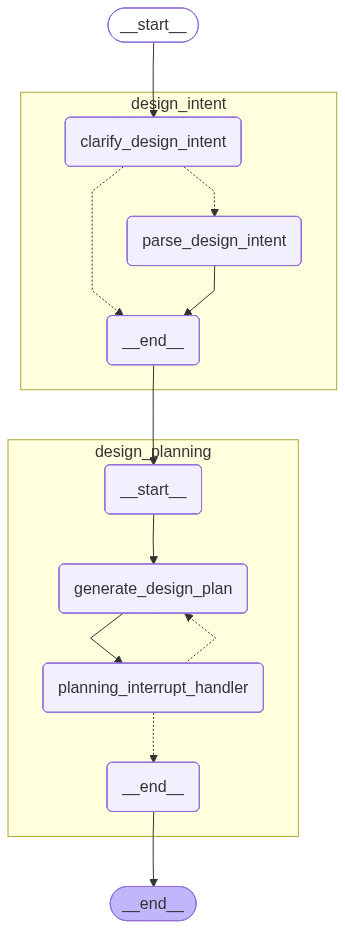

In [11]:
display(
    Image(
        connected_agent.get_graph(xray=True).draw_mermaid_png()
    )
)


In [12]:
thread = {"configurable": {"thread_id": "connected-5"}}

for chunk in connected_agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Design a solid cube with a side length of 50 units."
            )
        ]
    },
    config=thread,
):
    if "__interrupt__" in chunk:
        interrupt_obj = chunk["__interrupt__"][0]
        print("\n--- HUMAN REVIEW REQUIRED ---")
        print(interrupt_obj.value["description"])


CustomException: Error occurred in python script [D:\PROJECTS\ALWIN Sir\CAD_Agent\src\cad_agent_from_scratch\design_planning_workflow.py] at line number [48] with error message ['design_intent']